<a href="https://colab.research.google.com/github/dellaanima/NLP_GoingDeeper/blob/main/10/Project_Translator_Transformer_SentencePiece_otherData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Korean - English Translation Transformer Model



**Table of Contents**

## Rubric

# Import Modules

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,046 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120831 files and dire

In [3]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.5 MB/s eta 0:00:00


In [4]:
import re
import os
import io
import random   #학습 데이터 섞기
import tarfile
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm   #학습과정 시각화
from tqdm import tqdm_notebook   #학습과정 시각화
import tensorflow as tf
import sentencepiece as spm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm

import pickle
import seaborn

In [5]:
plt.rcParams['font.family'] = 'NanumBarunGothic'  # 나눔바른고딕 폰트 사용

# About the Dataset

https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

이전 프로젝트에서 사용한 데이터와 동일한 데이터 이기 때문에, 08/Project_Translator_Seq2Seq+Attention_Original.ipynb 에서 수행한 전처리 과정을 동일하게 수행하여, Pickle 파일로 가져와 바로 사용함.


In [6]:
#  전처리 끝낸, pickle 파일 (DataFrame) 불러오기
pickle_file_path = './dataset_2.pkl'
with open(pickle_file_path, 'rb') as file:
    dataset = pickle.load(file)

print("Loaded DataFrame:")
display(dataset)

Loaded DataFrame:


,kor,eng
0,bible coloring 은 성경의 아름다운 이야기를 체험 할 수 있는 컬러링 앱...,<sos> bible coloring is a coloring application...
1,씨티은행에서 일하세요 ?,<sos> do you work at a city bank ? <eos>
2,푸리토의 베스트셀러는 해외에서 입소문만으로 4차 완판을 기록하였다 .,"<sos> purito s bestseller , which recorded 4th..."
3,11장에서는 예수님이 이번엔 나사로를 무덤에서 불러내어 죽은 자 가운데서 살리셨습니다 .,<sos> in chapter 11 jesus called lazarus from ...
4,"6 . 5 , 7 , 8 사이즈가 몇 개나 더 재입고 될지 제게 알려주시면 감사하겠...",<sos> i would feel grateful to know how many s...
...,...,...
99994,드림파크 복합코스 경기장 주변에 둘러볼 만한 곳이 있나요 ?,<sos> is there a place to go sightseeing aroun...
99995,드림파크 복합코스 경기장 주변에는 생태공원이 있어서 자연을 즐기기에 좋은 장소입니다 .,<sos> because there is an ecological park near...
99996,드림파크 복합코스 경기장에는 몇 시부터 입장이 가능한가요 ?,<sos> what time can i enter the dream park com...
99997,드림파크 복합코스 경기장에서는 어떤 종목들이 열리나요 ?,<sos> what kind of events are held on dream pa...


SentencePiece : sp_tokenize 함수에서 sentencepice 패키지 내장 함수로 양끝 토큰 처리 할거여서, 위에 수행 했던 작업 제거함.

In [7]:
# eng 칼럼의 모든 row에 대해 <sos>와 <eos> 제거
dataset['eng'] = dataset['eng'].str.replace('<sos>', '').str.replace('<eos>', '')

In [8]:
dataset

,kor,eng
0,bible coloring 은 성경의 아름다운 이야기를 체험 할 수 있는 컬러링 앱...,bible coloring is a coloring application that...
1,씨티은행에서 일하세요 ?,do you work at a city bank ?
2,푸리토의 베스트셀러는 해외에서 입소문만으로 4차 완판을 기록하였다 .,"purito s bestseller , which recorded 4th roug..."
3,11장에서는 예수님이 이번엔 나사로를 무덤에서 불러내어 죽은 자 가운데서 살리셨습니다 .,in chapter 11 jesus called lazarus from the t...
4,"6 . 5 , 7 , 8 사이즈가 몇 개나 더 재입고 될지 제게 알려주시면 감사하겠...",i would feel grateful to know how many stocks...
...,...,...
99994,드림파크 복합코스 경기장 주변에 둘러볼 만한 곳이 있나요 ?,is there a place to go sightseeing around the...
99995,드림파크 복합코스 경기장 주변에는 생태공원이 있어서 자연을 즐기기에 좋은 장소입니다 .,because there is an ecological park near drea...
99996,드림파크 복합코스 경기장에는 몇 시부터 입장이 가능한가요 ?,what time can i enter the dream park complex ...
99997,드림파크 복합코스 경기장에서는 어떤 종목들이 열리나요 ?,what kind of events are held on dream park co...


### Tokenize the Dataset


https://github.com/keras-team/keras-docs-ko/blob/master/sources/preprocessing/text.md

- tokenize 함수는, Encoder, Decoder Dataset 에 맞게 토큰화를 시키고, 모델의 입력이 될  tensor 와 tokenizer 를 return 한다.

[tf.keras.preprocessing.text.Tokenizer(...) 객체]
- 객체 생성 후,  
- tokenizer.fit_on_texts(corpus_input)메서드로 tokenizer 객체에 corpus_input 주입하여 tokenizer를 학습시키는 과정을 수행한다.
- fit_on_text(text) 일때, text 는 List, Pandas Seires 도 가능
- 단어들을 토큰화하며 각 단어에 고유한 정수 인덱스를 부여합니다. (가장 빈도가 높은 것부터, 낮은 인덱스 부여)  

- 한국어는 형태소 단위로 쪼개진 데이터를 입력으로, 영어는 그냥 원래 Corpus 를 입력으로


In [9]:
# train the sentencepiece tokenizer
def train_sp_tokenizer(corpus, model_type='unigram', vocab_size=30000, lang="ko"):
    input_file = f'./dataset/{lang}_spm_input.txt'

    with open(input_file, 'w', encoding='utf-8') as f:
        for sent in corpus:
            f.write('{}\n'.format(sent))

    sp_model_root='sentencepiece'
    if not os.path.isdir(sp_model_root): os.mkdir(sp_model_root)

    prefix = 'tokenizer_%s_%s' % (lang,model_type+str(vocab_size))
    prefix = os.path.join(sp_model_root, prefix) # 저장될 tokenizer 모델에 붙는 이름
    pad_id=0
    bos_id=1 #<start> token을 1으로 설정
    eos_id=2 #<end> token을 2으로 설정
    unk_id=3 #<unknown> token을 3으로 설정
    character_coverage = 1.0 # to reduce character set

    # model_type = model_type # Choose from unigram (default), bpe, char, or word
    input_argument = '--input=%s --pad_id=%s --bos_id=%s --eos_id=%s --unk_id=%s '
    input_argument += '--model_prefix=%s --vocab_size=%s --character_coverage=%s --model_type=%s'

    cmd = input_argument%(input_file, pad_id, bos_id, eos_id, unk_id, prefix, vocab_size, character_coverage, model_type)

    spm.SentencePieceTrainer.Train(cmd)
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{prefix}.model')

    return tokenizer


#Get tokenizer & tensor
def sp_tokenize(data, vocab_size, langue):
    tokenizer = train_sp_tokenizer(data, 'unigram', vocab_size, langue)
    if langue == "en":
        tokenizer.set_encode_extra_options("bos:eos")

    tensor = data.apply(tokenizer.EncodeAsIds).tolist()
    tensor = tf.keras.preprocessing.sequence.pad_sequences(
        tensor,
        padding='post',
        maxlen=None
    )
    return tensor, tokenizer

In [28]:
enc_tensor, enc_tokenizer = sp_tokenize(dataset["kor"], 30000, "ko")
dec_tensor, dec_tokenizer  = sp_tokenize(dataset["eng"],12993, "en")


RuntimeError: Internal: src/trainer_interface.cc(661) [(trainer_spec_.vocab_size()) == (model_proto->pieces_size())] Vocabulary size too high (25000). Please set it to a value <= 12993.

<br>

# 모델 설계 및 학습


## 모델 설계 : Transformer


### Positional Encoding Layer  & Multihead Attention Layer

In [11]:
#Positional Encoding
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i)/d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table



#MultiHeadAttention
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )
        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights



#Position-wise Feed-Forward Network
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)

        return out



#Mask 레이어
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask



### Encoder & Decoder Layer



In [12]:
#Encoder Layer
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual

        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, enc_attn



#Decoder Layer
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual

        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn


### Encoder & Decoder

In [13]:
#Encoder
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout)
                        for _ in range(n_layers)]

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns



#Decoder
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout)
                            for _ in range(n_layers)]


    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns


### Transformer Model



In [14]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))


    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns



# 모델 학습

### LearningRateScheduler

In [15]:

class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.cast(step, tf.float32) ** -0.5
        arg2 = tf.cast(step, tf.float32) * (self.warmup_steps ** -1.5)

        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)



<br>

#### 학습 하이퍼파리미터 설정



<br>

#### 모델 학습 함수 설정

In [16]:
# 손실 함수
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)


In [17]:
learning_rate = LearningRateScheduler(d_model=512)
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [18]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다.
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

# 학습 과정 출력 함수 정의

In [19]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([0-9?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [21]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        seaborn.heatmap(
            data,
            square=True,
            vmin=0.0, vmax=1.0,
            cbar=False, ax=ax,
            xticklabels=x, yticklabels=y
        )

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print(f"[Encoder Layer(=Self Attention) {layer + 1} ]")
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()


    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print(f"[Decoder Self Layer {layer + 1} ]")
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()


        print(f"[Decoder Layer(Context Vector By Decoder Input) {layer + 1}]")
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()


# 번역 생성 함수
def evaluate(
    sentence,
    model,
    src_tokenizer, tgt_tokenizer,
    enc_maxlen, dec_maxlen,
):

    def idx_to_text(idx):
        return tgt_tokenizer.decode_ids(idx)

    sentence = preprocess_sentence(sentence)


    pieces = src_tokenizer.encode_as_pieces(sentence)
    _input = [src_tokenizer.encode_as_ids(sentence)]

    sos_idx = tgt_tokenizer.bos_id()
    eos_idx = tgt_tokenizer.eos_id()

    _input = tf.keras.preprocessing.sequence.pad_sequences(
        _input,
        maxlen=enc_maxlen,
        padding='post'
    )

    ids = []
    output = tf.expand_dims([sos_idx], 0)

    for i in range(dec_maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, output, enc_padding_mask, combined_mask, dec_padding_mask)

        predicted_id = tf.argmax(
            tf.math.softmax(predictions, axis=-1)[0, -1]
        ).numpy().item()

        if predicted_id == eos_idx:
            result = idx_to_text(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = idx_to_text(ids)
    return pieces, result, enc_attns, dec_attns, dec_enc_attns

# 번역 생성 및 Attention 시각화 결합

def translate(
    sentence,
    model,
    src_tokenizer, tgt_tokenizer,
    enc_maxlen, dec_maxlen,
    plot_attention=False,
):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(
        sentence,
        model,
        src_tokenizer, tgt_tokenizer,
        enc_maxlen, dec_maxlen,
    )

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)
    else:
        print("Korean Sentence:".rjust(18), sentence)
        print("English Sentence:".rjust(18), result, end="\n\n")


In [22]:
examples = [
    "아버지가 방에 들어가신다.",
    "저는 지금 공부를 하고 있어요.",
    "비가 올 수 있으니 꼭 우산을 챙기세요.",
    "컴퓨터가 고장났어요.",
    "저희 내일 저녁 7시에 만날래요?",
    "현재 날씨는 28도 입니다.",
    "당신을 정말 사랑해요.",
    "저는 음악을 들으면서 산책하는 것을 좋아해요.",
    "최근에 재밌게 본 영화가 있나요?",
    "여행 가고 싶어요."
]


In [23]:
def train_model(enc_tensor, dec_tensor, enc_tokenizer, dec_tokenizer):
    enc_maxlen, dec_maxlen = enc_tensor.shape[-1], dec_tensor.shape[-1]

    for epoch in range(EPOCHS):
        total_loss = 0

        idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
        random.shuffle(idx_list)
        t = tqdm_notebook(idx_list)

        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns = \
            train_step(
                enc_tensor[idx:idx+BATCH_SIZE],
                dec_tensor[idx:idx+BATCH_SIZE],
                transformer,
                optimizer
            )

            total_loss += batch_loss

            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.3f' % (total_loss.numpy() / (batch + 1)))

        if (epoch+1) % 5 == 0:
            print(f"[EPOCH {epoch}]")
            for example in examples:
                translate(
                    example,
                    transformer,
                    enc_tokenizer, dec_tokenizer,
                    enc_maxlen, dec_maxlen,
                    plot_attention=False
                )

        if (epoch+1) == EPOCHS:
            translate(
                examples[0],
                transformer,
                enc_tokenizer, dec_tokenizer,
                enc_maxlen, dec_maxlen,
                plot_attention=True
            )

## 모델 생성 및 학습


In [29]:
transformer = Transformer(
    n_layers=2,
    d_model=256,
    n_heads=8,
    d_ff=128,
    dropout=0.2,
    pos_len=200,
    shared=True,
    src_vocab_size=30000, tgt_vocab_size=12993
)

#### 모델 학습 + 모델 성능 확인

In [30]:

BATCH_SIZE = 64
EPOCHS = 10

<ipython-input-23-f80adb630dd9>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1455 [00:00<?, ?it/s]

  0%|          | 0/1455 [00:00<?, ?it/s]

  0%|          | 0/1455 [00:00<?, ?it/s]

  0%|          | 0/1455 [00:00<?, ?it/s]

  0%|          | 0/1455 [00:00<?, ?it/s]

[EPOCH 4]
  Korean Sentence: 아버지가 방에 들어가신다.
 English Sentence: father in the room , my father is .

  Korean Sentence: 저는 지금 공부를 하고 있어요.
 English Sentence: i studying for studying now .

  Korean Sentence: 비가 올 수 있으니 꼭 우산을 챙기세요.
 English Sentence: can t rain , but take a rain check .

  Korean Sentence: 컴퓨터가 고장났어요.
 English Sentence: computer broke up .

  Korean Sentence: 저희 내일 저녁 7시에 만날래요?
 English Sentence: can you meet us tomorrow at the dinner ?

  Korean Sentence: 현재 날씨는 28도 입니다.
 English Sentence: the weather is 2 is 8 .

  Korean Sentence: 당신을 정말 사랑해요.
 English Sentence: i love you so much .

  Korean Sentence: 저는 음악을 들으면서 산책하는 것을 좋아해요.
 English Sentence: i like to listen to music and walking .

  Korean Sentence: 최근에 재밌게 본 영화가 있나요?
 English Sentence: recently , movies recently ?

  Korean Sentence: 여행 가고 싶어요.
 English Sentence: traveling to travel .



  0%|          | 0/1455 [00:00<?, ?it/s]

  0%|          | 0/1455 [00:00<?, ?it/s]

  0%|          | 0/1455 [00:00<?, ?it/s]

  0%|          | 0/1455 [00:00<?, ?it/s]

  0%|          | 0/1455 [00:00<?, ?it/s]

[EPOCH 9]
  Korean Sentence: 아버지가 방에 들어가신다.
 English Sentence: father in the dormitory entering the room .

  Korean Sentence: 저는 지금 공부를 하고 있어요.
 English Sentence: i m studying right now .

  Korean Sentence: 비가 올 수 있으니 꼭 우산을 챙기세요.
 English Sentence: take it off to the rain , so please bring up your umbrella .

  Korean Sentence: 컴퓨터가 고장났어요.
 English Sentence: this is broken down .

  Korean Sentence: 저희 내일 저녁 7시에 만날래요?
 English Sentence: don t you meet tomorrow at 7 o clock ?

  Korean Sentence: 현재 날씨는 28도 입니다.
 English Sentence: the weather is 2 weather 8 .

  Korean Sentence: 당신을 정말 사랑해요.
 English Sentence: i love you .

  Korean Sentence: 저는 음악을 들으면서 산책하는 것을 좋아해요.
 English Sentence: i like to listen to a walking listening to my listen .

  Korean Sentence: 최근에 재밌게 본 영화가 있나요?
 English Sentence: is there any movie recently made recently ?

  Korean Sentence: 여행 가고 싶어요.
 English Sentence: i want to go on a trip .

[Encoder Layer(=Self Attention) 1 ]


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


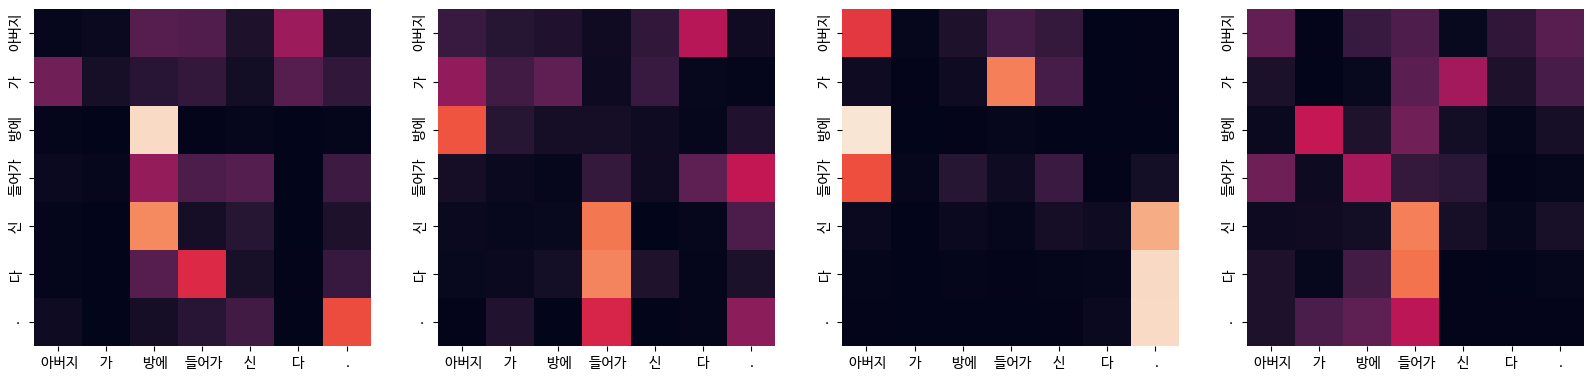

[Encoder Layer(=Self Attention) 2 ]


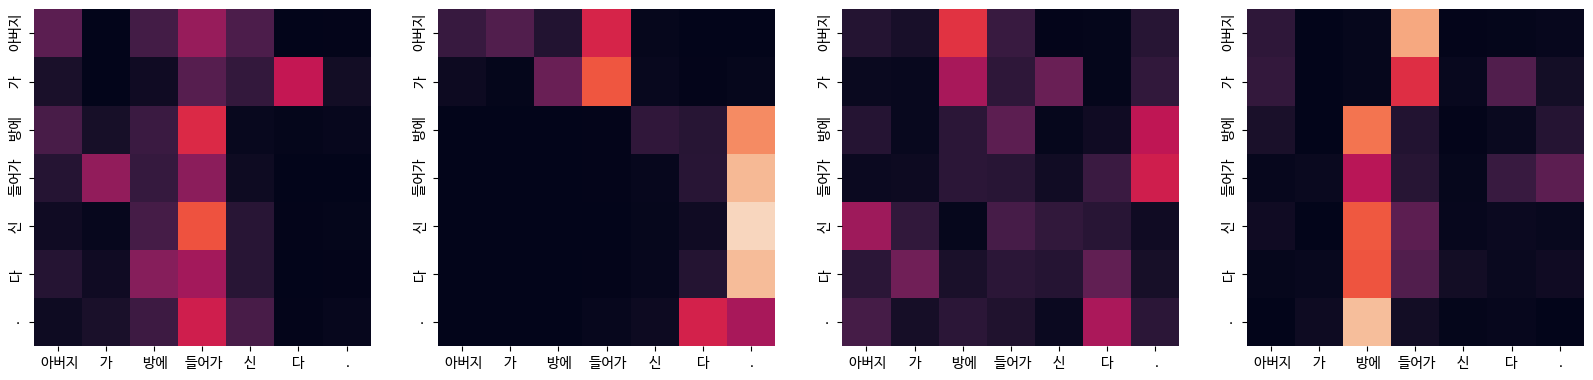

[Decoder Self Layer 1 ]


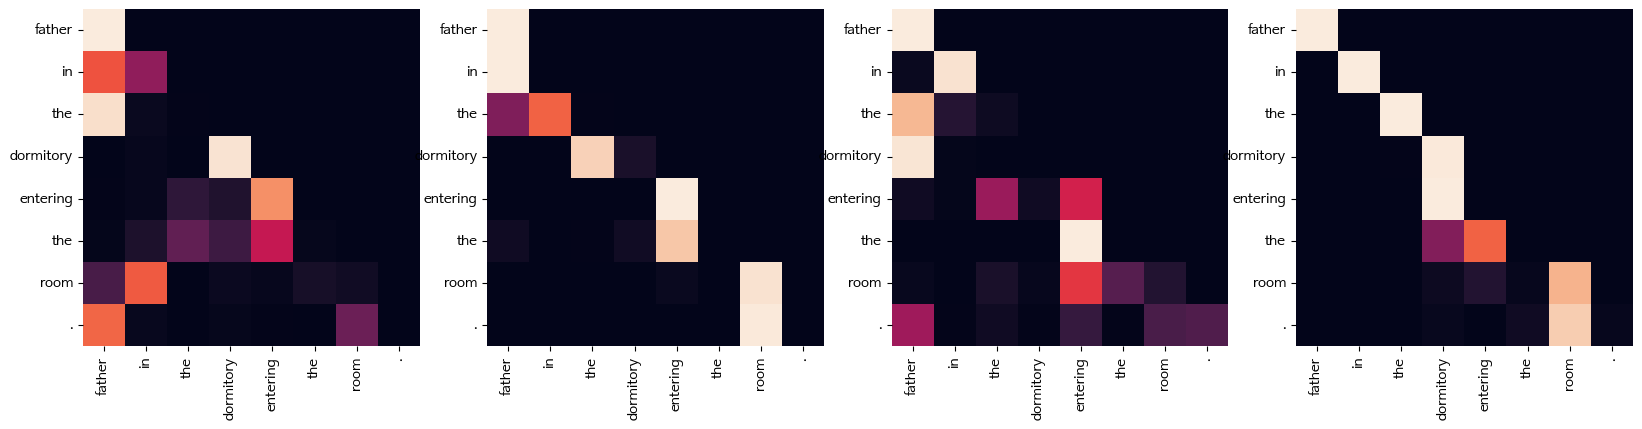

[Decoder Layer(Context Vector By Decoder Input) 1]


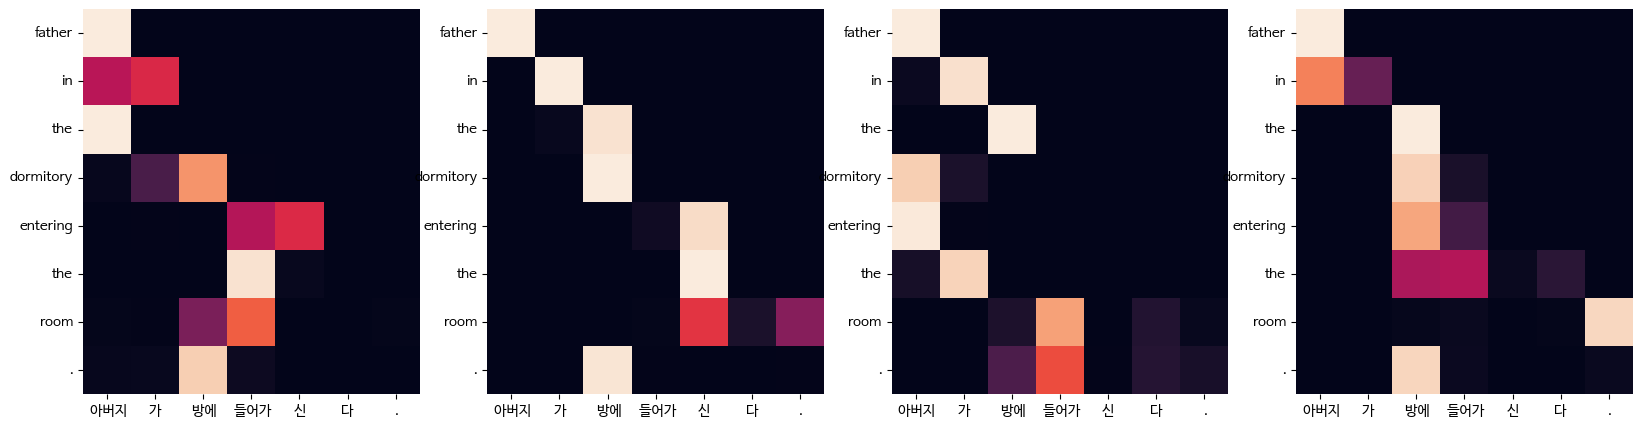

[Decoder Self Layer 2 ]


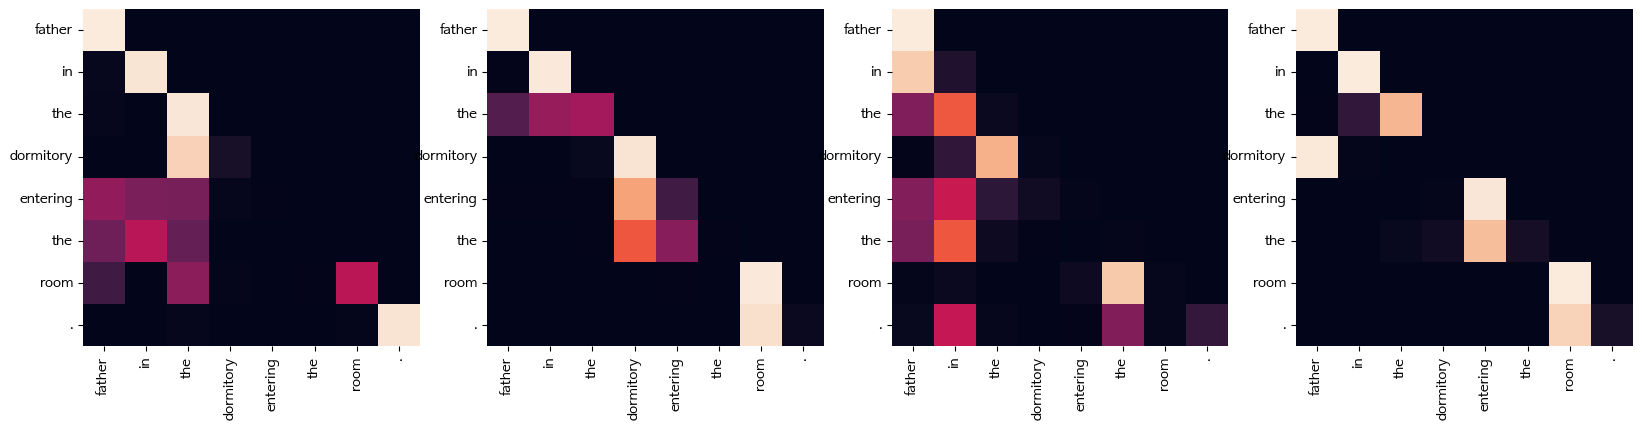

[Decoder Layer(Context Vector By Decoder Input) 2]


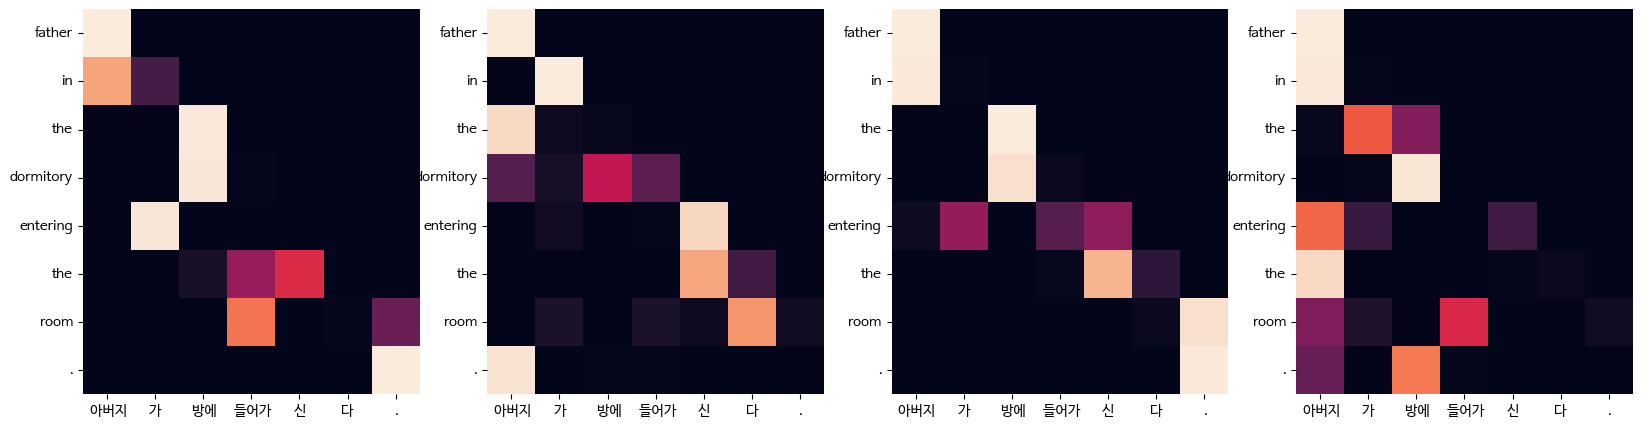

In [31]:
train_model(enc_tensor, dec_tensor,enc_tokenizer, dec_tokenizer)

# Trial + 10 epoch

<ipython-input-23-f80adb630dd9>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1455 [00:00<?, ?it/s]

  0%|          | 0/1455 [00:00<?, ?it/s]

  0%|          | 0/1455 [00:00<?, ?it/s]

  0%|          | 0/1455 [00:00<?, ?it/s]

  0%|          | 0/1455 [00:00<?, ?it/s]

[EPOCH 4]
  Korean Sentence: 아버지가 방에 들어가신다.
 English Sentence: my father has entered the room .

  Korean Sentence: 저는 지금 공부를 하고 있어요.
 English Sentence: i m studying right now .

  Korean Sentence: 비가 올 수 있으니 꼭 우산을 챙기세요.
 English Sentence: take it off the rain , take an umbrella .

  Korean Sentence: 컴퓨터가 고장났어요.
 English Sentence: the computer was broken .

  Korean Sentence: 저희 내일 저녁 7시에 만날래요?
 English Sentence: can we meet to meet at 7 o clock tomorrow ?

  Korean Sentence: 현재 날씨는 28도 입니다.
 English Sentence: the weather is 2 units too .

  Korean Sentence: 당신을 정말 사랑해요.
 English Sentence: i love you so much .

  Korean Sentence: 저는 음악을 들으면서 산책하는 것을 좋아해요.
 English Sentence: i like to listen to a walking listening to music .

  Korean Sentence: 최근에 재밌게 본 영화가 있나요?
 English Sentence: have recently you watch recently ?

  Korean Sentence: 여행 가고 싶어요.
 English Sentence: traveling to around .



  0%|          | 0/1455 [00:00<?, ?it/s]

  0%|          | 0/1455 [00:00<?, ?it/s]

  0%|          | 0/1455 [00:00<?, ?it/s]

  0%|          | 0/1455 [00:00<?, ?it/s]

  0%|          | 0/1455 [00:00<?, ?it/s]

[EPOCH 9]
  Korean Sentence: 아버지가 방에 들어가신다.
 English Sentence: you can enter in your room .

  Korean Sentence: 저는 지금 공부를 하고 있어요.
 English Sentence: i m studying right now .

  Korean Sentence: 비가 올 수 있으니 꼭 우산을 챙기세요.
 English Sentence: take it off , brings an umbrella is sure to bring off your umbrella .

  Korean Sentence: 컴퓨터가 고장났어요.
 English Sentence: this is broken up .

  Korean Sentence: 저희 내일 저녁 7시에 만날래요?
 English Sentence: can we meet you at 7 p . we meet tomorrow ?

  Korean Sentence: 현재 날씨는 28도 입니다.
 English Sentence: the weather is 2 hours too .

  Korean Sentence: 당신을 정말 사랑해요.
 English Sentence: i love you so much .

  Korean Sentence: 저는 음악을 들으면서 산책하는 것을 좋아해요.
 English Sentence: i like i enjoy listening to a listen to a listen to music though i am enjoy taking a walk .

  Korean Sentence: 최근에 재밌게 본 영화가 있나요?
 English Sentence: is there any fun movie that watching recently ?

  Korean Sentence: 여행 가고 싶어요.
 English Sentence: traveling .

[Encoder Layer(=Self Attention) 1 ]


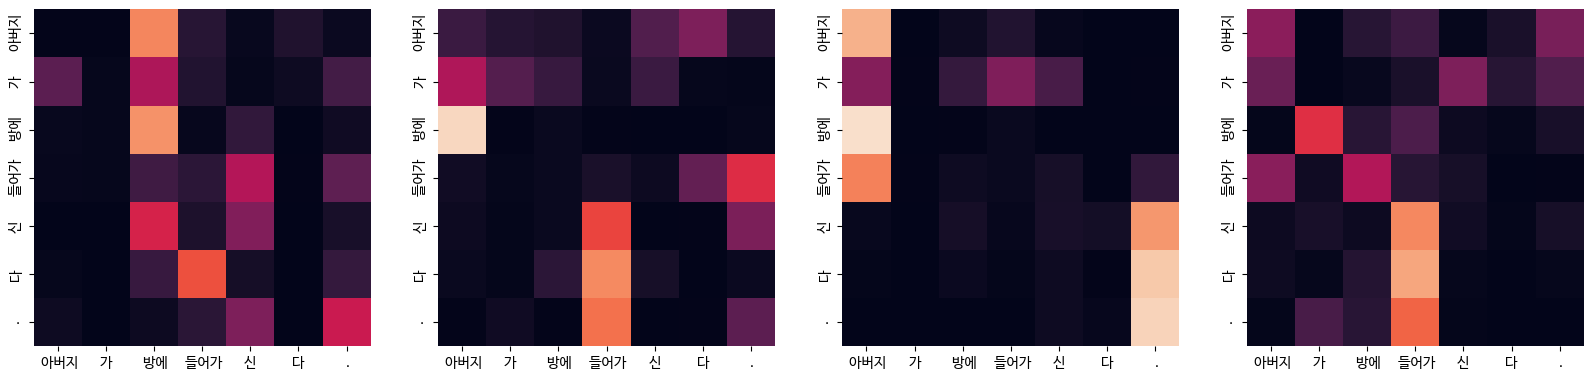

[Encoder Layer(=Self Attention) 2 ]


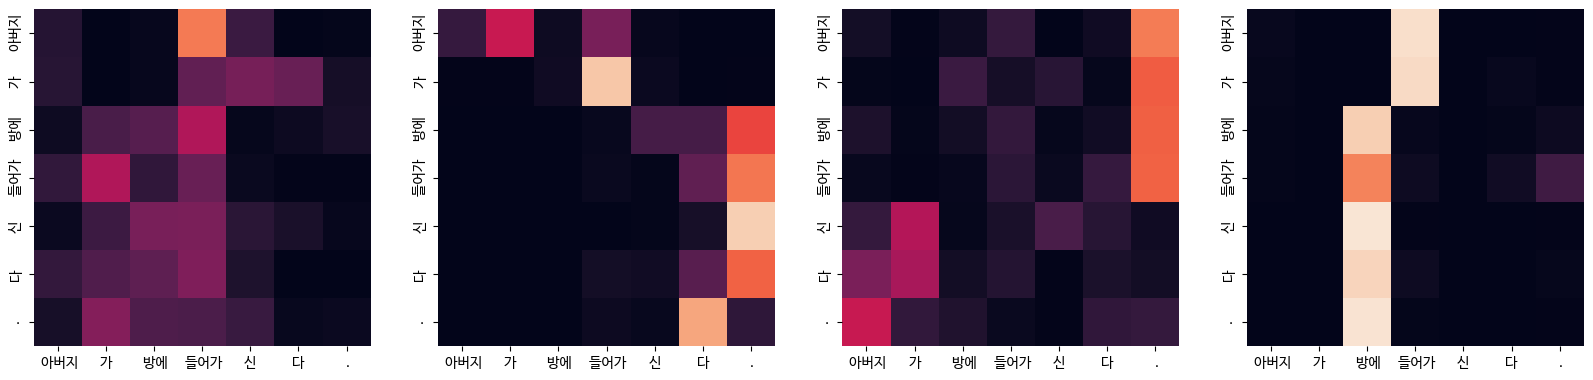

[Decoder Self Layer 1 ]


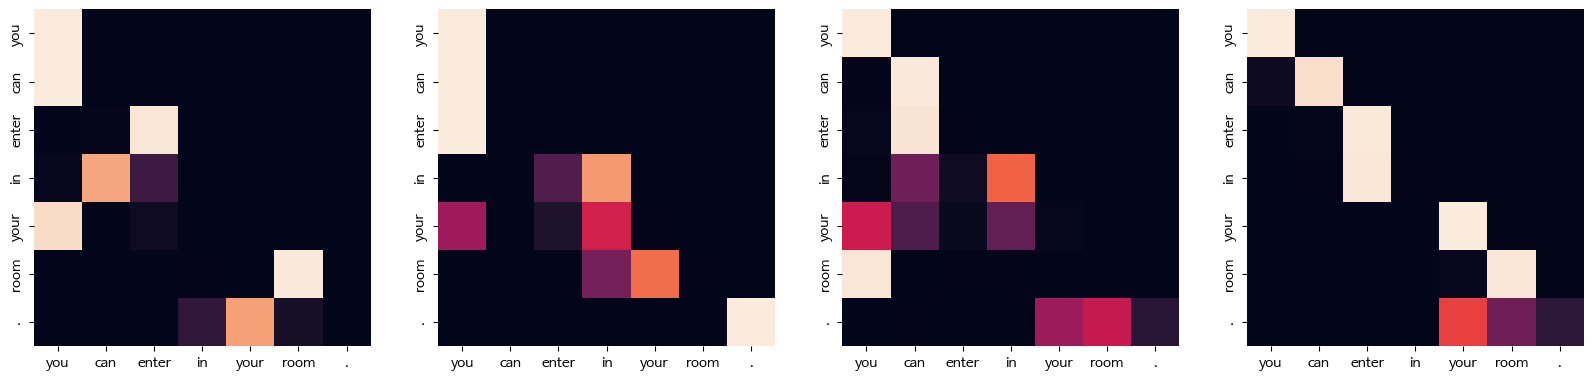

[Decoder Layer(Context Vector By Decoder Input) 1]


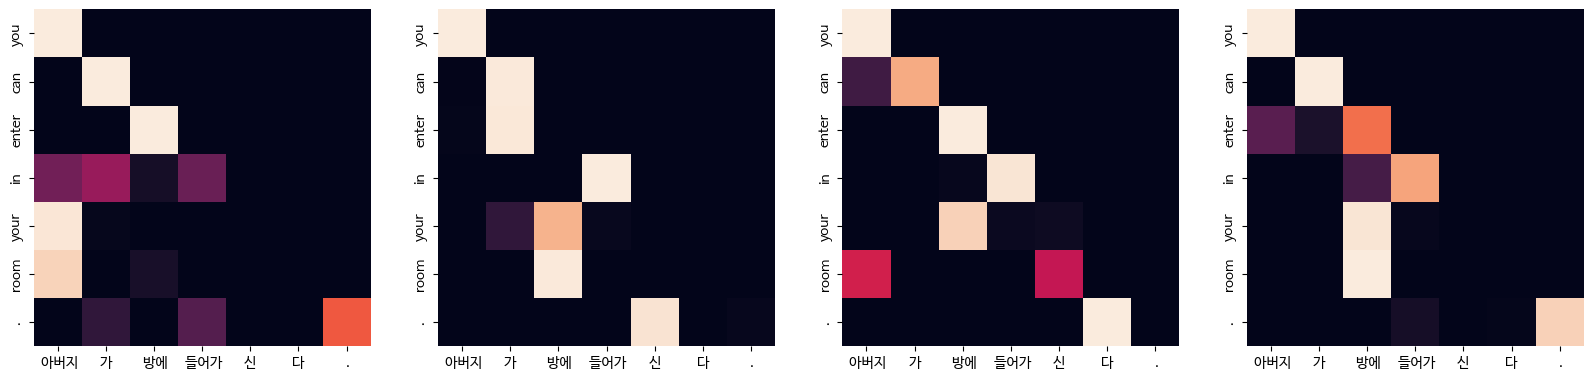

[Decoder Self Layer 2 ]


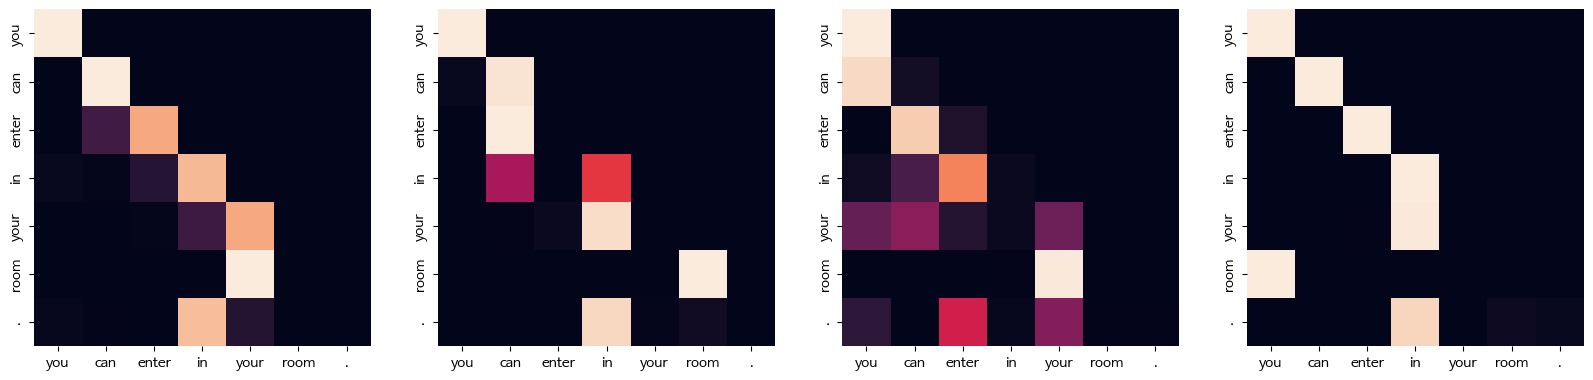

[Decoder Layer(Context Vector By Decoder Input) 2]


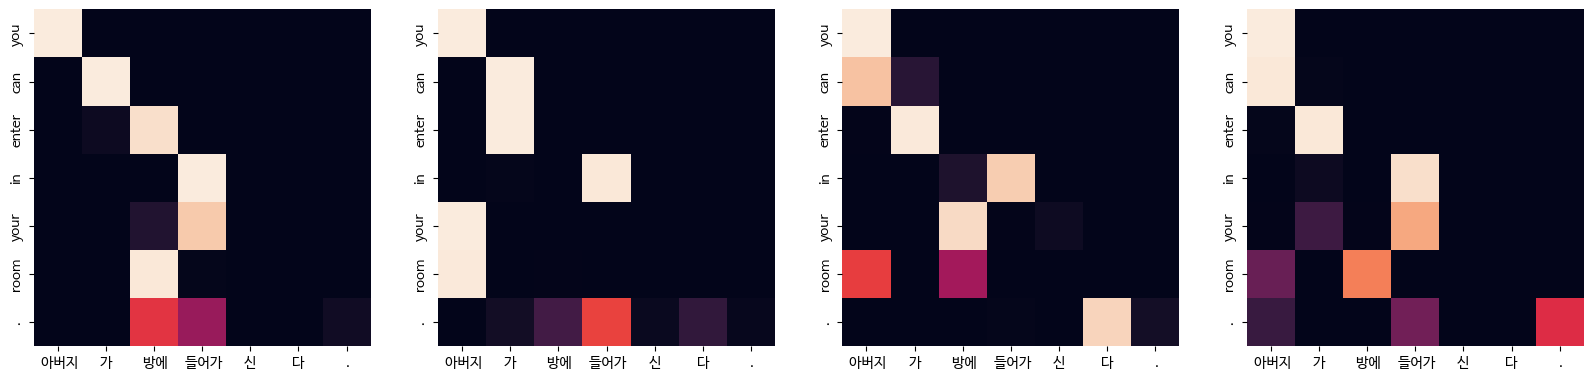

In [32]:
train_model(enc_tensor, dec_tensor,enc_tokenizer, dec_tokenizer)